# Graph of the teams

First, to display our data, we can show a graph made with all marvel 616 universe, where two teams are connected if they share at least one member.

In [1]:
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt

import ast

from itertools import combinations

from tqdm.notebook import tqdm

from fa2 import ForceAtlas2

import random

In [2]:
df = pd.read_csv("../data/marvel_teams.csv")

df["members"] = df["members"].apply(ast.literal_eval)

df.head()

,team_name,members
0,Oracle Inc. (Earth-616),"[Anita Savvy (Earth-616), Caleb Alexander (Ear..."
1,Metal Mobsters (Earth-616),[]
2,Knights of the Atomic Round Table (Earth-616),"[Anthony Stark (Earth-616), Bruce Banner (Eart..."
3,Yoruba,[]
4,Emissaries of Evil (Electro) (Earth-616),"[Manuel Eloganto (Earth-616), Maxwell Dillon (..."


With this dataframe, we can get all characters that are members of one team at list.

In [3]:
characters = list(set(df["members"].sum()))
characters[:5]

['Makiko Morioka (Earth-616)',
 'Mary Mercy (Earth-616)',
 'F. Schneebaum (Earth-616)',
 'File:Hegerfors (Earth-616) from Daredevil Vol 1 231 001.png',
 'Beta (Ape) (Earth-616)']

In [4]:
len(characters)

12298

In [5]:
def getTeams(character, df):
  teams = list(df[df.apply(lambda x: character in x["members"], axis=1)]["team_name"])
  return list(combinations(teams, 2))

Now it is time to create the graph :).

Each node is going to be a team, and a link will reflect that they have one memberr in common at least

In [6]:
team_combinations = []

for character in tqdm(characters):
  team_comb = getTeams(character, df)
  if len(team_comb):
    team_combinations += team_comb

team_combinations[:5]

  0%|          | 0/12298 [00:00<?, ?it/s]

[('Anti-Symbiote Task Force (Earth-616)',
  'Federal Bureau of Investigation (Earth-616)'),
 ('Illuminati (Earth-616)', 'House of Agon (Earth-616)'),
 ('Illuminati (Earth-616)', "Dard'van Sect (Earth-616)"),
 ('House of Agon (Earth-616)', "Dard'van Sect (Earth-616)"),
 ('Paragons Squad (Earth-616)', 'Corsairs Squad (Earth-616)')]

In [7]:
G = nx.Graph()

G.add_nodes_from(list(df["team_name"]))

G.add_edges_from(team_combinations)

len(G.nodes()), len(G.edges())

(3051, 15009)

In [8]:
GCC = G.subgraph(max(nx.connected_components(G), key=len))

len(GCC.nodes()), len(GCC.edges())

(1381, 14917)

In [9]:
sum([x[1] for x in GCC.degree])/len(GCC.nodes)

21.603186097031138

Now, let's draw our network

In [10]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=600)

100%|█████████████████████████████████████████| 600/600 [07:03<00:00,  1.42it/s]

BarnesHut Approximation  took  13.58  seconds
Repulsion forces  took  389.23  seconds
Gravitational forces  took  0.84  seconds
Attraction forces  took  16.13  seconds
AdjustSpeedAndApplyForces step  took  2.47  seconds


In [11]:
sizes = []
alphas = []
colors = []
max_degree = max(GCC.degree(), key=lambda x: x[1])[1]

for node in tqdm(GCC.nodes):
  size = GCC.degree(node) * 25 + 100
  alpha = max([GCC.degree(node)/max_degree, .2])
  
  colors.append((random.random(), random.random(), random.random()))
  
  sizes.append(size)
  alphas.append(alpha)

  0%|          | 0/1381 [00:00<?, ?it/s]

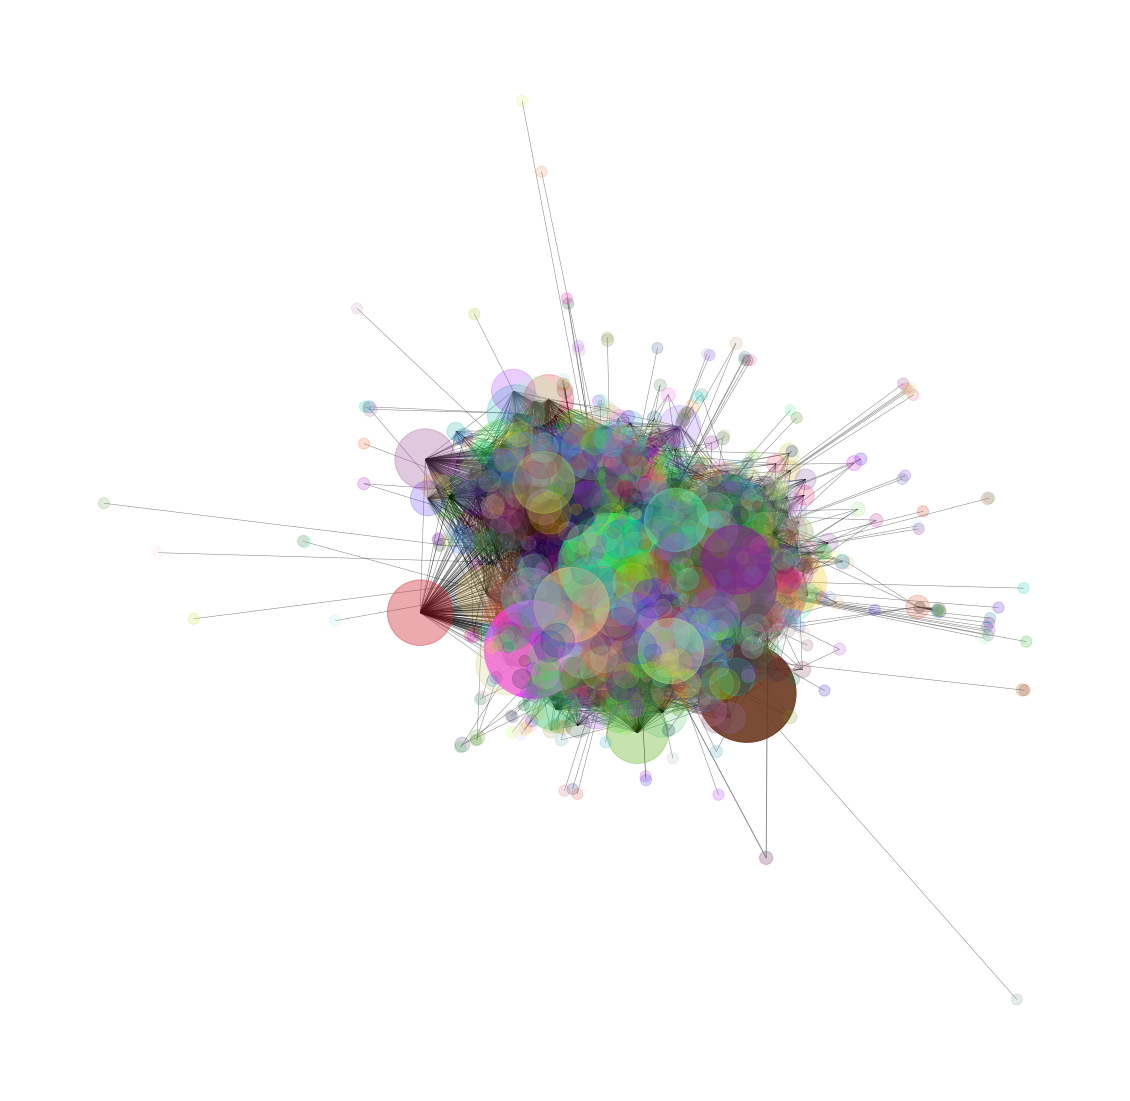

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))

nx.draw_networkx_nodes(GCC,
                       positions,
                       linewidths  = 1,
                       node_size   = sizes,
                       node_color  = colors,
                       alpha       = alphas,
                       ax          = ax
                      )

nx.draw_networkx_edges(GCC,
                       positions,
                       edge_color  = "black",
                       arrowstyle  = "-",
                       alpha       = 0.5,
                       width       = .5,
                       ax          = ax
                      )  
plt.axis("off")

plt.show()

In [13]:
sorted_teams = sorted(GCC.degree, key=lambda x: x[1], reverse=True)

sorted_teams[:10]

[('Strategic Homeland Intervention, Enforcement and Logistics Division (Earth-616)',
  432),
 ('50-State Initiative (Earth-616)', 383),
 ('Avengers (Earth-616)', 378),
 ('X-Men (Earth-616)', 305),
 ('Thunderbolts (Earth-616)', 256),
 ('United States Army (Earth-616)', 231),
 ('Hydra (Earth-616)', 229),
 ('Hellfire Club (Earth-616)', 224),
 ('Defenders (Earth-616)', 221),
 ('Secret Defenders (Earth-616)', 214)]

In [14]:
# most members

df["number_members"] = df["members"].apply(lambda x: len(x))

df.sort_values("number_members", ascending=False)

,team_name,members,number_members
2879,"Strategic Homeland Intervention, Enforcement a...","[Abigail Brand (Earth-616), Abner Jenkins (Ear...",640
690,New York City Police Department (Earth-616),"[Al Farrell (Earth-616), Alan Greene (Earth-61...",577
3025,National Socialist German Workers Party (Earth...,"[Admiral von Roeder (Earth-616), Adolf Hitler ...",405
566,United States Army (Earth-616),"[101st Airborne Division (Earth-616), 82nd Air...",395
1163,Hydra (Earth-616),"[Aaron Nicholson (Earth-616), Adi (Earth-616),...",282
...,...,...,...
803,Chicken Hawks (Earth-616),[],0
2099,Walking Dead (Japanese) (Earth-616),[],0
2095,Impossible Kids (Earth-616),[],0
808,Victor Creed Clones (Romulus) (Earth-616),[],0


In [15]:
df.loc[df["team_name"].str.startswith("Aven")]

,team_name,members,number_members
19,Avengers (1950s) (Earth-616),"[Aquaria Neptunia (Earth-616), Duvid Fortunov ...",9
24,Avengers Idea Mechanics (Earth-616),"[Agent Larry (Earth-616), Aikku Jokinen (Earth...",20
626,Avengers Support Crew (Earth-616),"[Arnold Roth (Earth-616), Diane Arliss (Earth-...",18
682,Avengers (Earth-616),"[Aaron Stack (Earth-616), Abyss (Ex Nihilo's) ...",115
822,Avengers Artificial Intelligence Squad (Earth-...,"[Alexis (Earth-616), Doombot (Avenger) (Earth-...",7
865,Avengers (Doctor Doom's) (Earth-616),"[Brunnhilde (Earth-616), Delroy Garrett Jr. (E...",8
1059,Avengers of the Supernatural (Earth-616),"[Eric Brooks (Earth-616), Johnathon Blaze (Ear...",6
1065,"Avengers (1,000,000 BC) (Earth-616)","[Agamotto (Earth-616), Black Panther (1,000,00...",8
1236,Avengers (Spies) (Earth-616),"[Emma Peel (Earth-616), John Steed (Earth-616)]",2
1507,Avengers Compound Support Staff (Earth-616),"[Carlos Alvarez (Earth-616), Consuela Sanchez ...",16
